Individual assignment
===
1. Preprocessing
2. Sanity checks
3. First-level analysis

# 0. Setup

## Imports

---
Use SPM

In [35]:
from nipype.interfaces import spm

matlab_cmd = "/opt/spm12/run_spm12.sh /opt/mcr/v97/ script"
spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)

if spm.SPMCommand().version != "":
    use_spm = True
    print(spm.SPMCommand().version)
else:
    use_spm = False

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


12.7771


stty: 'standard input': Inappropriate ioctl for device


---

In [36]:
import jupyter_black

jupyter_black.load()

from nipype import config

cfg = dict(
    logging=dict(workflow_level="INFO"),
    execution={
        "stop_on_first_crash": "True",
        "hash_method": "content",
        "remove_unnecessary_outputs": "True",
    },
)
config.update_config(cfg)

import os
from os.path import join as opj
import json
from nipype.interfaces.fsl import (
    BET,
    ExtractROI,
    FAST,
    FLIRT,
    ImageMaths,
    MCFLIRT,
    SliceTimer,
    Threshold,
    IsotropicSmooth,
    FLIRT,
    FNIRT,
    ApplyWarp,
)
from nipype.interfaces.fsl.utils import RobustFOV
import nibabel as nib
from nilearn import image, plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node
from IPython.display import Image

# Check if ENV variables are set
print("'FSLDIR':", os.environ["FSLDIR"])
print("'FSLOUTPUTTYPE':", os.environ["FSLOUTPUTTYPE"])

fslpath = os.environ["FSLDIR"]

# FSL
# os.environ["LD_LIBRARY_PATH"] = os.environ["LD_LIBRARY_PATH"] + os.pathsep + "/usr/lib/fsl/5.0"

'FSLDIR': /opt/fsl-5.0.11
'FSLOUTPUTTYPE': NIFTI


In [37]:
os.environ["LD_LIBRARY_PATH"]

''

## Download data and MNI atlas

In [38]:
os.path.exists("data/ds000102")

True

In [39]:
# add mni template to fsl dir
# os.makedirs(fslpath + "/data/standard", exist_ok=True)
# !wget 'https://ucloud.univie.ac.at/index.php/s/bnj6HPWqImlpFjD/download' -O mniatlas.zip
# !unzip -oq mniatlas.zip -d ${FSLDIR}/data/standard

In [40]:
mni_template = os.path.join(fslpath, "data/standard/MNI152_T1_2mm_brain.nii.gz")

os.path.exists(mni_template)

True

## Experiment parameters

In [41]:
project_root_dir = os.getcwd()
experiment_dir = project_root_dir + "/output"
output_dir = "datasink"
working_dir = "working_dir"
data_dir = project_root_dir + "/data/ds000102"

# list of subject identifiers
subject_list = ["02"]

# list of session identifiers
task_list = ["flanker"]

# Smoothing widths to apply
fwhm = [4]  # [4, 8]

# TR of functional images
with open(data_dir + "/task-flanker_bold.json", "rt") as fp:
    task_info = json.load(fp)
TR = task_info["RepetitionTime"]

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4


# os.environ["FSLOUTPUTTYPE"] = "NIFTI"

os.makedirs("data", exist_ok=True)
os.makedirs("output/working_dir", exist_ok=True)
os.makedirs(fslpath + "/data/standard", exist_ok=True)

### Inspect Data

In [42]:
anat = nib.load(
    f"{data_dir}/sub-{subject_list[0]}/anat/sub-{subject_list[0]}_T1w.nii.gz"
)
func = nib.load(
    f"{data_dir}/sub-{subject_list[0]}/func/sub-{subject_list[0]}_task-flanker_run-1_bold.nii.gz"
)

anat_data = anat.get_fdata()
func_data = func.get_fdata()  # [:, :, :, 4:]


# check the shape of the files
print("shape of anat file:", anat_data.shape)
print("shape of func file:", func_data.shape)

print(
    f"\nWe have {func_data.shape[2]} slices with a resolution of {func_data.shape[0]}x{func_data.shape[1]} voxels and {func_data.shape[3]} timepoints"
)

shape of anat file: (176, 256, 256)
shape of func file: (64, 64, 40, 146)

We have 40 slices with a resolution of 64x64 voxels and 146 timepoints


In [43]:
TA = TR - (TR / func_data.shape[2])
print(f"TA: {TA}\nTR: {TR}")

TA: 1.95
TR: 2.0


#### Plot of anatomical image

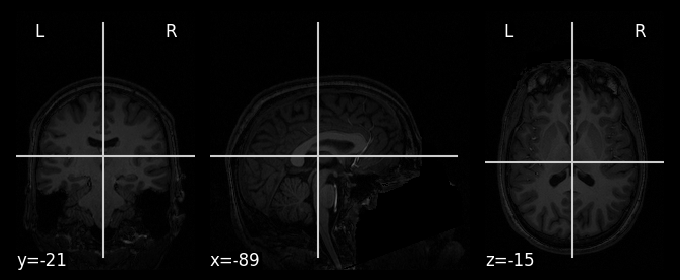

In [44]:
plotting.plot_anat(anat);

#### Plot of functional image

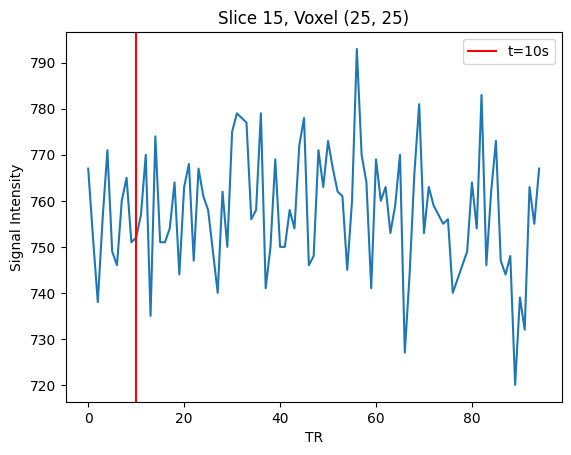

In [45]:
# define variables for number of slices, tr and ta

slice_no = 15
voxel_x = 25
voxel_y = 25

timepoints = slice(5, 100)
timepoint = 10

plt.plot(func_data[slice_no, voxel_x, voxel_y, timepoints])
plt.axvline(timepoint, color="red", label=f"t={timepoint}s")
plt.xlabel("TR")
plt.ylabel("Signal Intensity")
plt.title(f"Slice {slice_no}, Voxel {(voxel_x, voxel_y)}")
plt.legend();

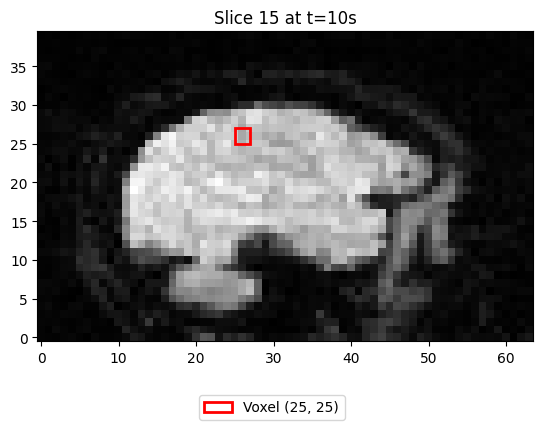

In [46]:
fig, ax = plt.subplots()
ax.imshow(func_data[slice_no, :, :, timepoint].T, cmap="gray", origin="lower")
rect = patches.Rectangle(
    (voxel_x, voxel_y),
    2,
    2,
    linewidth=2,
    edgecolor="r",
    facecolor="none",
    label=f"Voxel {(voxel_x, voxel_y)}",
)
ax.add_patch(rect)
ax.set_title(f"Slice {slice_no} at t={timepoint}s")
fig.legend(loc="lower center");

<div class="alert alert-info">everything looks alright</div>

# 1. Preprocessing

## Nodes for main workflow

In [47]:
# ExtractROI - remove first 4 volumes
# extract = Node(ExtractROI(t_min=4, t_size=-1, output_type="NIFTI"), name="extract")
extract = Node(
    ExtractROI(crop_list=[(0, -1), (0, -1), (0, -1), (4, -1)]), name="extract"
)  # alternative

# MCFLIRT - motion correction
realigner = Node(
    MCFLIRT(mean_vol=True, save_plots=True, output_type="NIFTI"), name="realigner"
)

# SliceTimer - correct for slice wise acquisition
slicetimer = Node(
    SliceTimer(
        index_dir=False, interleaved=True, output_type="NIFTI", time_repetition=TR
    ),
    name="slicetimer",
)

# Smooth - image smoothing
if use_spm:
    smooth = Node(Smooth(out_prefix="smooth_"), name="smooth")  # SPM
else:
    smooth = Node(IsotropicSmooth(), name="smooth")  # FSL
smooth.iterables = ("fwhm", fwhm)

# Artifact Detection - determines outliers in functional images
art = Node(
    ArtifactDetect(
        norm_threshold=2,
        zintensity_threshold=3,
        mask_type="spm_global",
        parameter_source="FSL",
        use_differences=[True, False],
        plot_type="svg",
    ),
    name="art",
)

In [48]:
Smooth.help()

Use spm_smooth for 3D Gaussian smoothing of image volumes.

http://www.fil.ion.ucl.ac.uk/spm/doc/manual.pdf#page=55

Examples
--------
>>> import nipype.interfaces.spm as spm
>>> smooth = spm.Smooth()
>>> smooth.inputs.in_files = 'functional.nii'
>>> smooth.inputs.fwhm = [4, 4, 4]
>>> smooth.run() # doctest: +SKIP

Inputs::

        [Mandatory]
        in_files: (a list of items which are a pathlike object or string
                  representing an existing file)
                list of files to smooth

        [Optional]
        fwhm: (a list of from 3 to 3 items which are a float or a float)
                3-list of fwhm for each dimension
        data_type: (an integer)
                Data type of the output images
        implicit_masking: (a boolean)
                A mask implied by a particular voxel value
        out_prefix: (a string, nipype default value: s)
                smoothed output prefix
        matlab_cmd: (a string)
                matlab command to use
        

## Coregistration workflow

221216-15:38:31,734 nipype.workflow INFO:
	 Generated workflow graph: /main/assignments/individual/output/working_dir/coreg_wf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /main/assignments/individual/output/working_dir/coreg_wf/graph.png (graph2use=colored, simple_form=True).


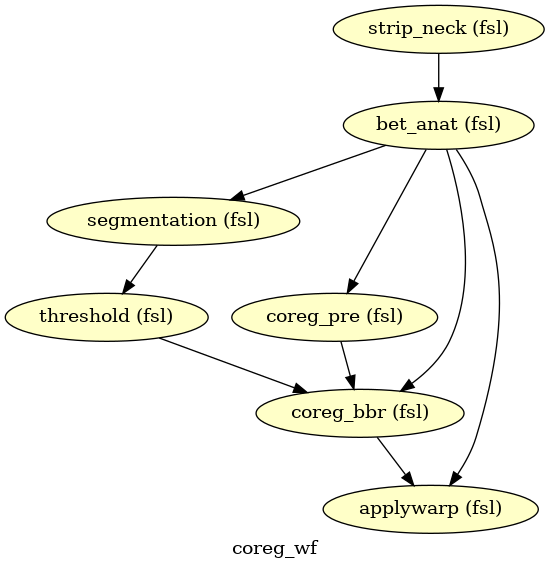

In [49]:
def create_fsl_coregflow(base_directory, apply_to_epis=False):
    """
    Creates FSL like coregistration worfklow

    Returns: Nipype Workflow object
    """

    coreg_wf = Workflow(name="coreg_wf", base_dir=base_directory)

    # Remove neck from anatomical image to improve skullstripping
    strip_neck = Node(RobustFOV(), name="strip_neck")

    # Skullstrip anatomical Image
    bet_anat = Node(
        BET(
            frac=0.2,
            # reduce_bias=True,
            output_type="NIFTI_GZ",
        ),
        name="bet_anat",
    )

    # T1 segmentation & bias field correction
    segmentation = Node(
        FAST(output_type="NIFTI_GZ", output_biascorrected=True),
        name="segmentation",
        mem_gb=4,
    )

    # Threshold WM probability image
    threshold = Node(
        Threshold(thresh=0.15, args="-bin", output_type="NIFTI_GZ"), name="threshold"
    )

    # Pre-alignment of functional images to anatomical images
    coreg_pre = Node(FLIRT(dof=6, output_type="NIFTI_GZ"), name="coreg_pre")

    # Use BBR cost function to improve the coregistration
    coreg_bbr = Node(
        FLIRT(
            dof=6,
            cost="bbr",
            schedule=os.path.join(os.getenv("FSLDIR"), "etc/flirtsch/bbr.sch"),
            output_type="NIFTI_GZ",
        ),
        name="coreg_bbr",
    )

    # Apply coregistration warp to functional images
    applywarp = Node(
        FLIRT(interp="spline", apply_isoxfm=4, output_type="NIFTI"), name="applywarp"
    )

    # connect nodes of coreg workflow
    coreg_wf.connect(
        [
            (strip_neck, bet_anat, [("out_roi", "in_file")]),
            (bet_anat, segmentation, [("out_file", "in_files")]),
            (segmentation, threshold, [(("partial_volume_files", get_wm), "in_file")]),
            (bet_anat, coreg_pre, [("out_file", "reference")]),
            (threshold, coreg_bbr, [("out_file", "wm_seg")]),
            (coreg_pre, coreg_bbr, [("out_matrix_file", "in_matrix_file")]),
            (bet_anat, coreg_bbr, [("out_file", "reference")]),
        ]
    )

    if apply_to_epis:
        coreg_wf.connect(coreg_bbr, "out_matrix_file", applywarp, "in_matrix_file")
        coreg_wf.connect(bet_anat, "out_file", applywarp, "reference")

    return coreg_wf


def get_wm(files):
    """
    Helper function to select WM segmentation file from segmentation output
    """
    return files[-1]


coreg_wf = create_fsl_coregflow(
    base_directory=opj(experiment_dir, working_dir), apply_to_epis=True
)

coreg_wf.write_graph(graph2use="colored", format="png", simple_form=True)
Image(filename=opj(coreg_wf.base_dir, "coreg_wf", "graph.png"))

## Normalization workflow

221216-15:38:32,103 nipype.workflow INFO:
	 Generated workflow graph: /main/assignments/individual/output/working_dir/norm_wf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /main/assignments/individual/output/working_dir/norm_wf/graph.png (graph2use=colored, simple_form=True).


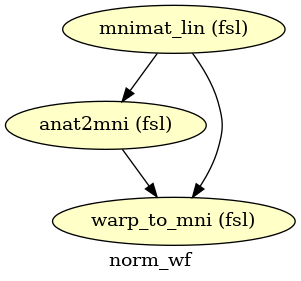

In [50]:
def create_fsl_normflow(base_directory, reference):
    """
    Creates FSL like normalization worfklow

    Returns: Nipype Workflow object
    """

    norm_wf = Workflow(name="norm_wf", base_dir=base_directory)

    # linear transformation of t1 to mni template
    mnimat_lin = Node(
        FLIRT(cost_func="normcorr", dof=12, reference=reference), name="mnimat_lin"
    )

    # non-linear transformation of t1 to mni (using params from linear transf.)
    anat2mni = Node(
        FNIRT(ref_file=reference, warped_file="warped.nii"), name="anat2mni"
    )

    # warp epi data to mni template
    warp_to_mni = Node(ApplyWarp(ref_file=reference), name="warp_to_mni")

    norm_wf.connect(
        [
            (mnimat_lin, anat2mni, [("out_matrix_file", "affine_file")]),
            (anat2mni, warp_to_mni, [("field_file", "field_file")]),
            (mnimat_lin, warp_to_mni, [("out_matrix_file", "postmat")]),
        ]
    )

    return norm_wf


norm_wf = create_fsl_normflow(
    base_directory=opj(experiment_dir, working_dir), reference=mni_template
)

norm_wf.write_graph(graph2use="colored", format="png", simple_form=True)
Image(filename=opj(norm_wf.base_dir, "norm_wf", "graph.png"))

## IO stream

In [51]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(
    IdentityInterface(fields=["subject_id", "task_name"]), name="infosource"
)
infosource.iterables = [("subject_id", subject_list), ("task_name", task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj(
    "sub-{subject_id}",
    "anat",
    "sub-{subject_id}_T1w.nii.gz",
)
func_file = opj(
    "sub-{subject_id}",
    "func",
    "sub-{subject_id}_task-{task_name}_run-1_bold.nii.gz",
)

templates = {"anat": anat_file, "func": func_file}
selectfiles = Node(SelectFiles(templates, base_directory=data_dir), name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(
    DataSink(base_directory=experiment_dir, container=output_dir), name="datasink"
)

## Use the following DataSink output substitutions
substitutions = [
    ("_subject_id_", "sub-"),
    ("_task_name_", "/task-"),
    ("_fwhm_", "fwhm-"),
    ("_roi", ""),
    ("_mcf", ""),
    ("_st", ""),
    ("_flirt", ""),
    (".nii_mean_reg", "_mean"),
    (".nii.par", ".par"),
]
subjFolders = [("fwhm-%s/" % f, "fwhm-%s_" % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Connect main workflow

In [52]:
# Create a preprocessing workflow
preproc_wf = Workflow(name="preproc_wf")
preproc_wf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc_wf.connect(
    [
        (
            infosource,
            selectfiles,
            [("subject_id", "subject_id"), ("task_name", "task_name")],
        ),
        (selectfiles, extract, [("func", "in_file")]),
        (extract, realigner, [("roi_file", "in_file")]),
        (realigner, slicetimer, [("out_file", "in_file")]),
        (
            selectfiles,
            coreg_wf,
            [
                ("anat", "strip_neck.in_file"),
            ],
        ),
        (
            realigner,
            coreg_wf,
            [
                ("mean_img", "coreg_pre.in_file"),
                ("mean_img", "coreg_bbr.in_file"),
            ],
        ),
        (
            slicetimer,
            coreg_wf,
            [("slice_time_corrected_file", "applywarp.in_file")],
        ),
        (
            coreg_wf,
            norm_wf,
            [
                ("segmentation.restored_image", "mnimat_lin.in_file"),
                ("segmentation.restored_image", "anat2mni.in_file"),
                ("applywarp.out_file", "warp_to_mni.in_file"),
            ],
        ),
        # (norm_wf, smooth, [("warp_to_mni.out_file", "in_file")]),  # FSL
        (norm_wf, smooth, [("warp_to_mni.out_file", "in_files")]),  # SPM
        (realigner, datasink, [("par_file", "preproc_wf.@par")]),
        # (smooth, datasink, [("out_file", "preproc_wf.@smooth")]),  # FSL
        (smooth, datasink, [("smoothed_files", "preproc_wf.@smooth")]),  # SPM
        (coreg_wf, art, [("applywarp.out_file", "realigned_files")]),
        (realigner, art, [("par_file", "realignment_parameters")]),
        (
            coreg_wf,
            datasink,
            [
                ("coreg_bbr.out_matrix_file", "preproc_wf.@mat_file"),
                ("bet_anat.out_file", "preproc_wf.@brain"),
            ],
        ),
        (
            norm_wf,
            datasink,
            [
                ("warp_to_mni.out_file", "preproc_wf.@warped_to_mni"),
                ("anat2mni.warped_file", "preproc_wf.@_file"),
            ],
        ),
        (
            art,
            datasink,
            [
                ("outlier_files", "preproc_wf.@outlier_files"),
                ("plot_files", "preproc_wf.@plot_files"),
            ],
        ),
    ]
)

## Visualize the complete workflow

221216-15:38:32,988 nipype.workflow INFO:
	 Generated workflow graph: /main/assignments/individual/output/working_dir/preproc_wf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /main/assignments/individual/output/working_dir/preproc_wf/graph.png (graph2use=colored, simple_form=True).


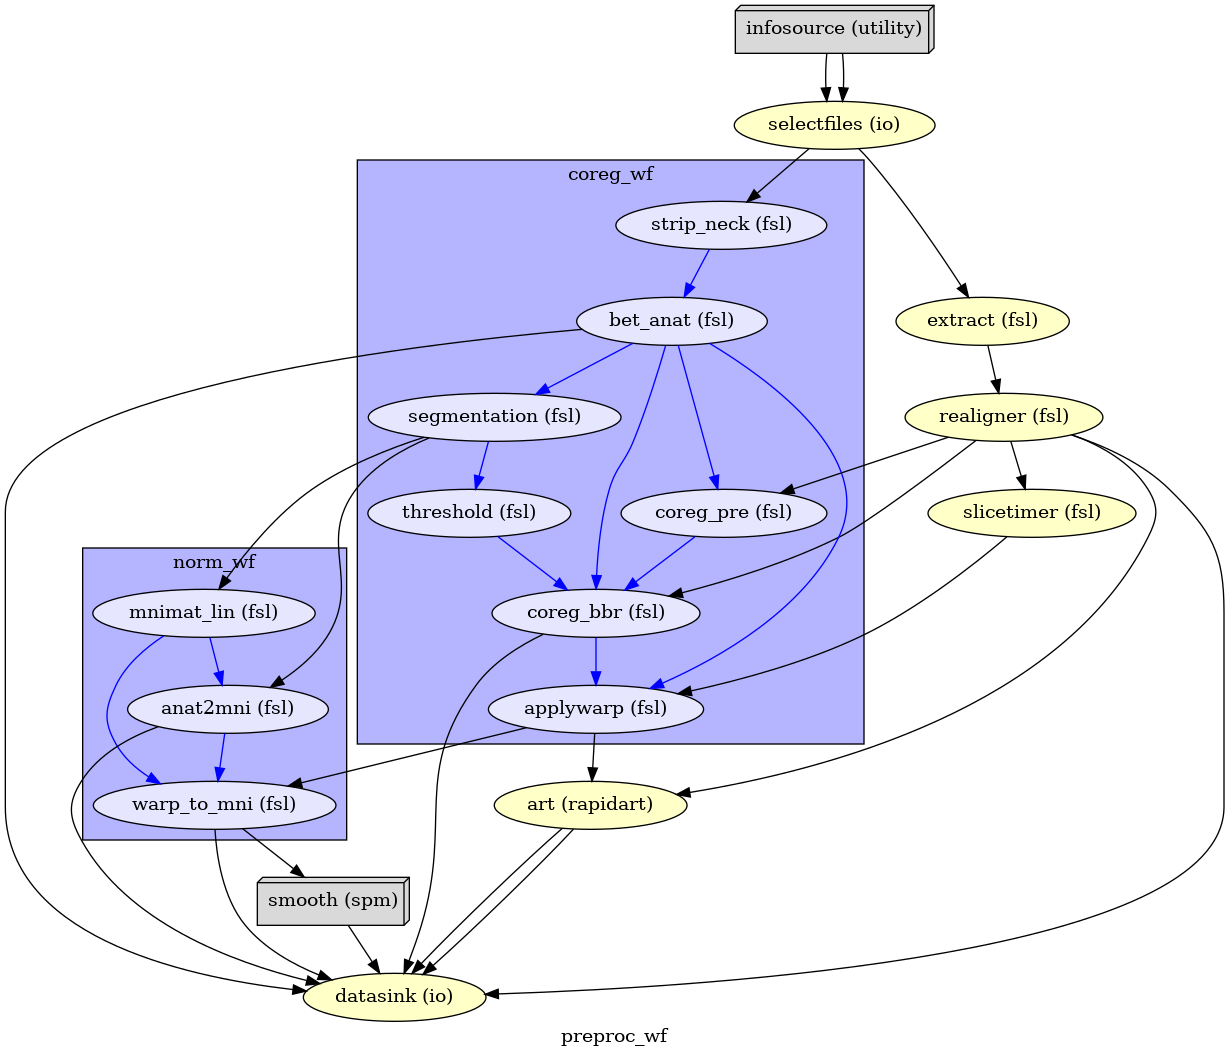

In [53]:
# Create preproc output graph
preproc_wf.write_graph(graph2use="colored", format="png", simple_form=True)

Image(filename=opj(preproc_wf.base_dir, "preproc_wf", "graph.png"))

221216-15:38:34,206 nipype.workflow INFO:
	 Generated workflow graph: /main/assignments/individual/output/working_dir/preproc_wf/graph.png (graph2use=flat, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /main/assignments/individual/output/working_dir/preproc_wf/graph.png (graph2use=flat, simple_form=True).


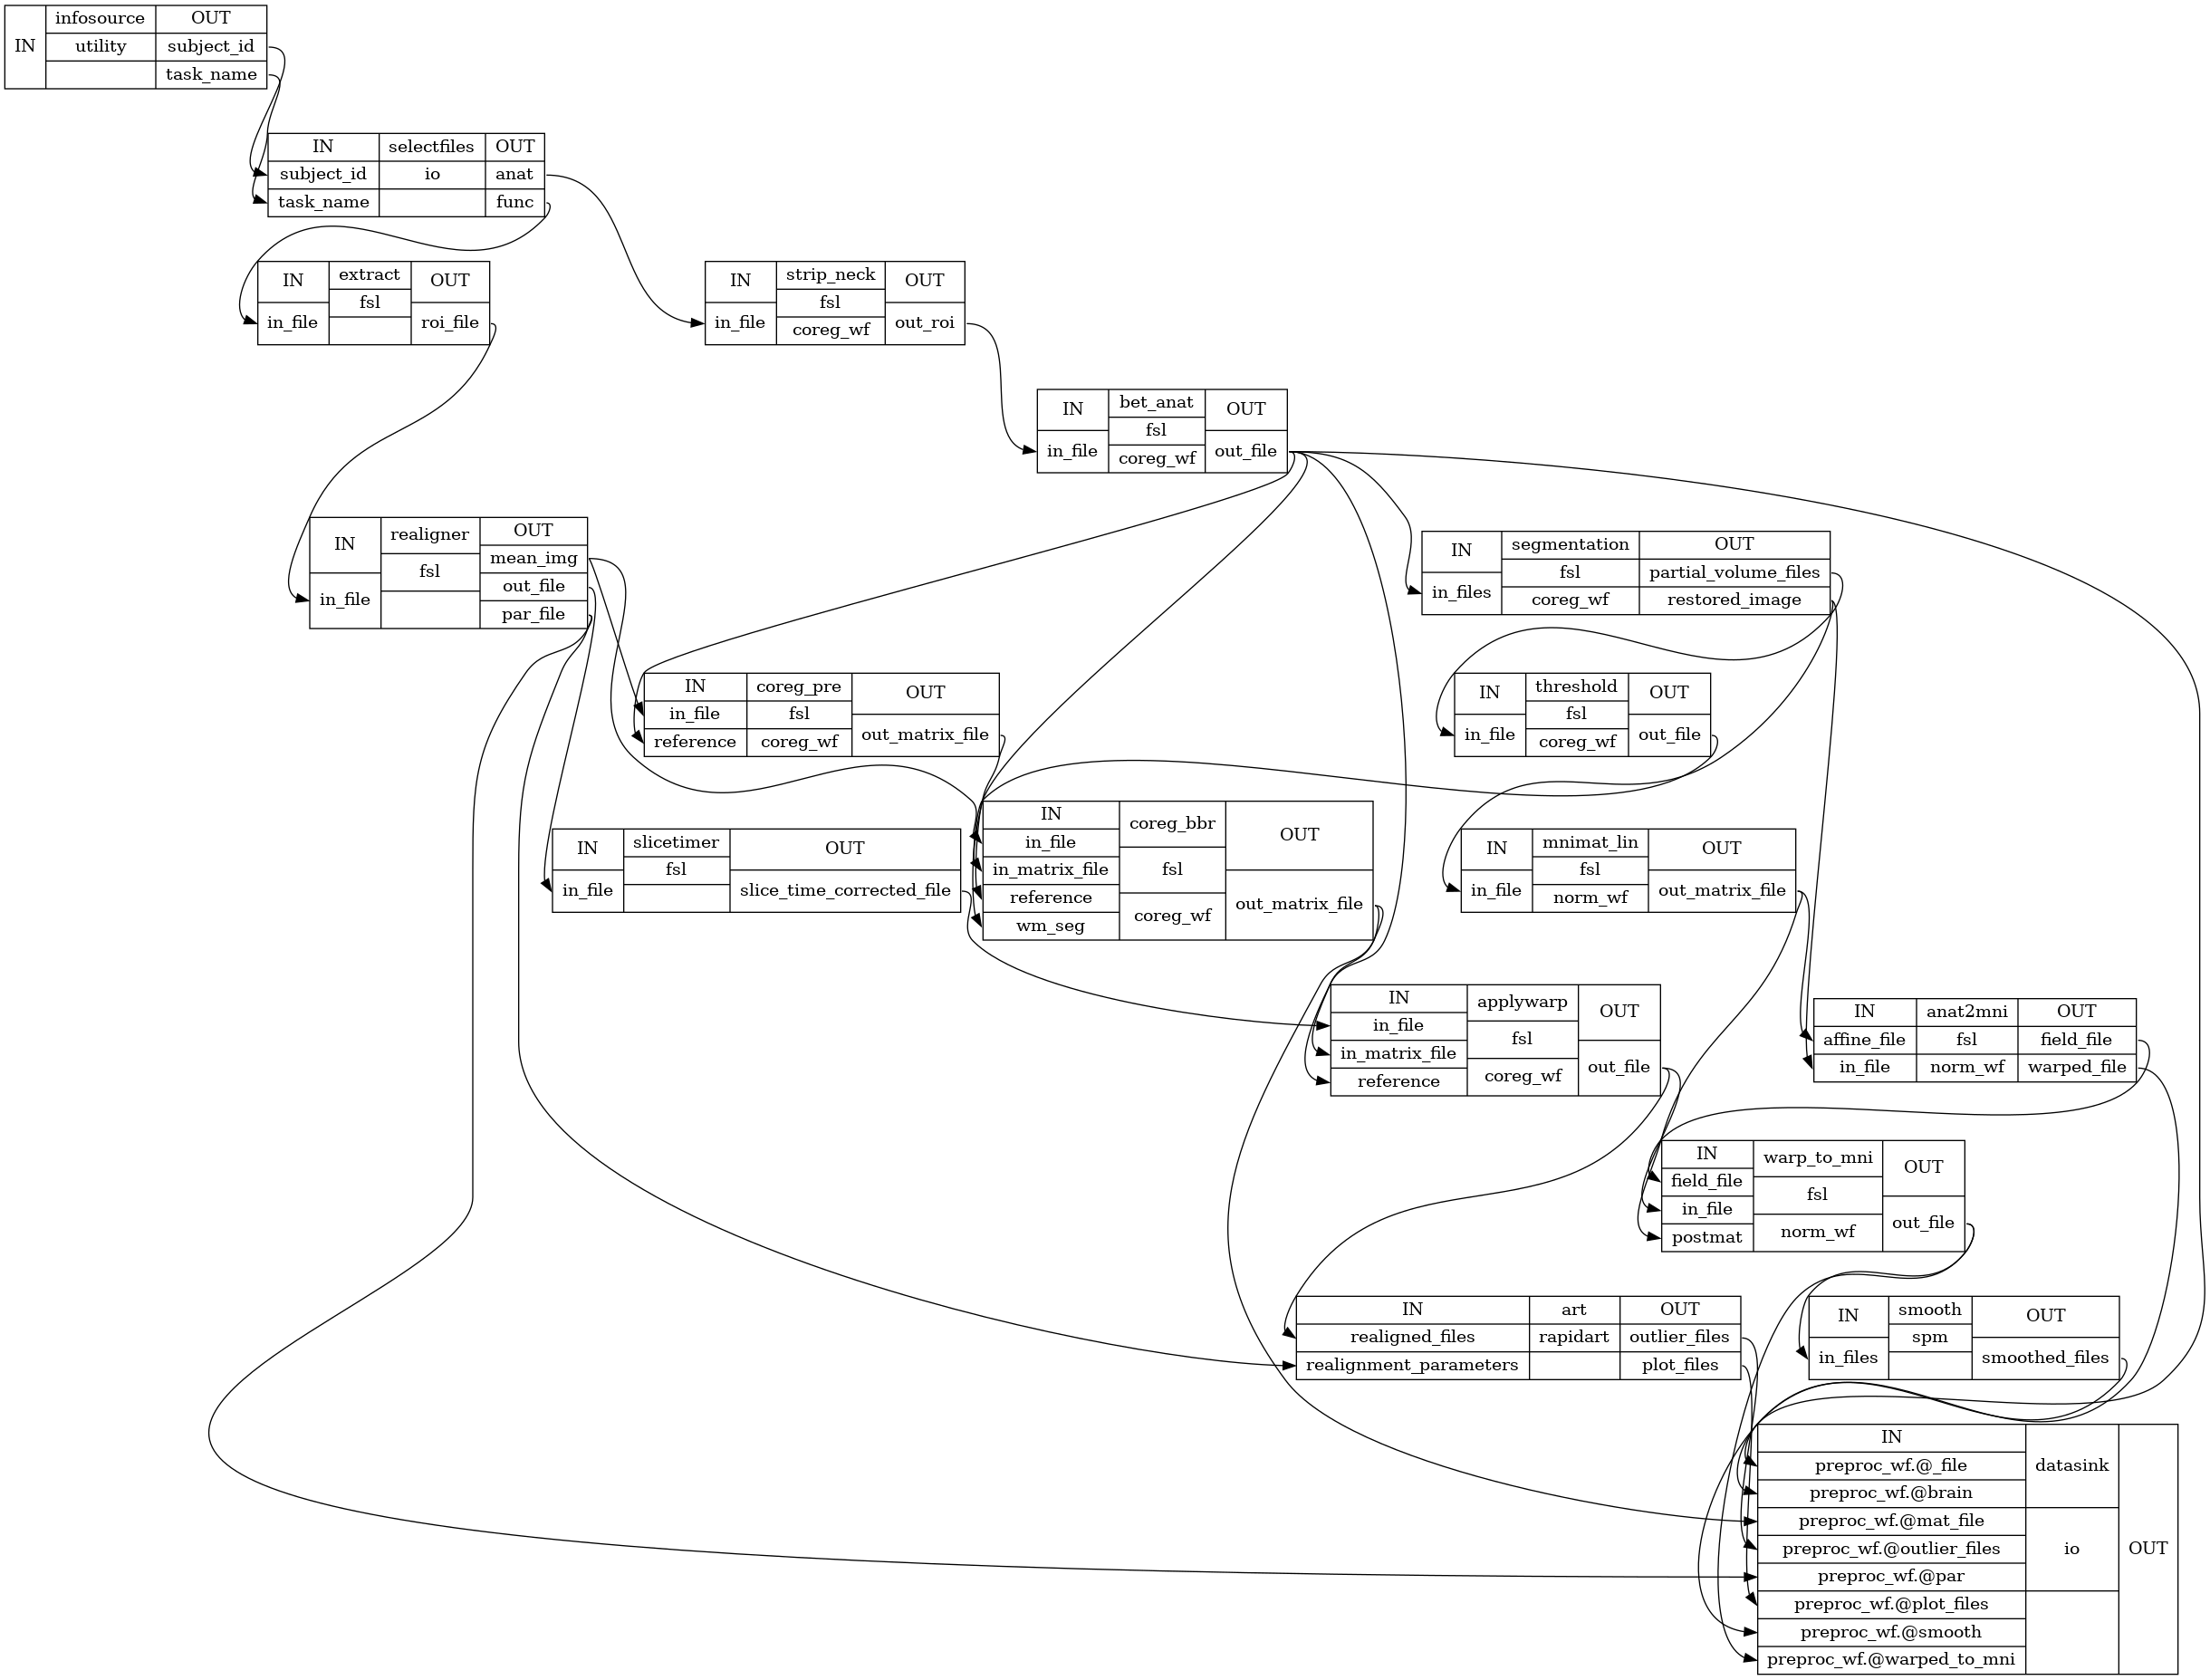

In [54]:
# Visualize the detailed graph
preproc_wf.write_graph(graph2use="flat", format="png", simple_form=True)
Image(filename=opj(preproc_wf.base_dir, "preproc_wf", "graph_detailed.png"))

## Run workflow

In [55]:
preproc_wf.run("MultiProc", plugin_args={"n_procs": 8})

221216-15:38:34,279 nipype.workflow INFO:
	 Workflow preproc_wf settings: ['check', 'execution', 'logging', 'monitoring']


INFO:nipype.workflow:Workflow preproc_wf settings: ['check', 'execution', 'logging', 'monitoring']


221216-15:38:34,321 nipype.workflow INFO:
	 Running in parallel.


INFO:nipype.workflow:Running in parallel.


221216-15:38:34,328 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221216-15:38:34,732 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.selectfiles" in "/main/assignments/individual/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/selectfiles".


INFO:nipype.workflow:[Node] Setting-up "preproc_wf.selectfiles" in "/main/assignments/individual/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/selectfiles".


221216-15:38:34,748 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


INFO:nipype.workflow:[Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


221216-15:38:34,757 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.002389s.


INFO:nipype.workflow:[Node] Finished "selectfiles", elapsed time 0.002389s.


221216-15:38:36,334 nipype.workflow INFO:
	 [Job 0] Completed (preproc_wf.selectfiles).


INFO:nipype.workflow:[Job 0] Completed (preproc_wf.selectfiles).


221216-15:38:36,353 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221216-15:38:36,972 nipype.workflow INFO:
	 [Job 1] Cached (preproc_wf.extract).


INFO:nipype.workflow:[Job 1] Cached (preproc_wf.extract).


221216-15:38:37,51 nipype.workflow INFO:
	 [Job 2] Cached (preproc_wf.coreg_wf.strip_neck).


INFO:nipype.workflow:[Job 2] Cached (preproc_wf.coreg_wf.strip_neck).


221216-15:38:38,902 nipype.workflow INFO:
	 [Job 3] Cached (preproc_wf.realigner).


INFO:nipype.workflow:[Job 3] Cached (preproc_wf.realigner).


221216-15:38:39,134 nipype.workflow INFO:
	 [Job 4] Cached (preproc_wf.coreg_wf.bet_anat).


INFO:nipype.workflow:[Job 4] Cached (preproc_wf.coreg_wf.bet_anat).


221216-15:38:40,335 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221216-15:38:40,926 nipype.workflow INFO:
	 [Job 5] Cached (preproc_wf.slicetimer).


INFO:nipype.workflow:[Job 5] Cached (preproc_wf.slicetimer).


221216-15:38:40,950 nipype.workflow INFO:
	 [Job 6] Cached (preproc_wf.coreg_wf.segmentation).


INFO:nipype.workflow:[Job 6] Cached (preproc_wf.coreg_wf.segmentation).


221216-15:38:40,980 nipype.workflow INFO:
	 [Job 7] Cached (preproc_wf.coreg_wf.coreg_pre).


INFO:nipype.workflow:[Job 7] Cached (preproc_wf.coreg_wf.coreg_pre).


221216-15:38:42,338 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221216-15:38:42,601 nipype.workflow INFO:
	 [Job 8] Cached (preproc_wf.coreg_wf.threshold).


INFO:nipype.workflow:[Job 8] Cached (preproc_wf.coreg_wf.threshold).


221216-15:38:42,668 nipype.workflow INFO:
	 [Job 9] Cached (preproc_wf.norm_wf.mnimat_lin).


INFO:nipype.workflow:[Job 9] Cached (preproc_wf.norm_wf.mnimat_lin).


221216-15:38:44,606 nipype.workflow INFO:
	 [Job 10] Cached (preproc_wf.coreg_wf.coreg_bbr).


INFO:nipype.workflow:[Job 10] Cached (preproc_wf.coreg_wf.coreg_bbr).


221216-15:38:44,662 nipype.workflow INFO:
	 [Job 11] Cached (preproc_wf.norm_wf.anat2mni).


INFO:nipype.workflow:[Job 11] Cached (preproc_wf.norm_wf.anat2mni).


221216-15:38:46,340 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221216-15:38:47,158 nipype.workflow INFO:
	 [Job 12] Cached (preproc_wf.coreg_wf.applywarp).


INFO:nipype.workflow:[Job 12] Cached (preproc_wf.coreg_wf.applywarp).


221216-15:38:48,343 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221216-15:38:49,59 nipype.workflow INFO:
	 [Job 13] Cached (preproc_wf.art).


INFO:nipype.workflow:[Job 13] Cached (preproc_wf.art).


221216-15:38:49,495 nipype.workflow INFO:
	 [Job 14] Cached (preproc_wf.norm_wf.warp_to_mni).


INFO:nipype.workflow:[Job 14] Cached (preproc_wf.norm_wf.warp_to_mni).


221216-15:38:50,342 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221216-15:38:53,774 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc_wf.smooth".


INFO:nipype.workflow:[Node] Outdated cache found for "preproc_wf.smooth".


221216-15:38:53,779 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc_wf.smooth


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc_wf.smooth


221216-15:38:53,785 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.smooth" in "/main/assignments/individual/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/_fwhm_4/smooth".


INFO:nipype.workflow:[Node] Setting-up "preproc_wf.smooth" in "/main/assignments/individual/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/_fwhm_4/smooth".


221216-15:38:53,792 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc_wf.smooth".


INFO:nipype.workflow:[Node] Outdated cache found for "preproc_wf.smooth".


221216-15:38:53,803 nipype.workflow INFO:
	 [Node] Executing "smooth" <nipype.interfaces.spm.preprocess.Smooth>


INFO:nipype.workflow:[Node] Executing "smooth" <nipype.interfaces.spm.preprocess.Smooth>
stty: 'standard input': Inappropriate ioctl for device


221216-15:40:14,29 nipype.workflow INFO:
	 [Node] Finished "smooth", elapsed time 67.958415s.


INFO:nipype.workflow:[Node] Finished "smooth", elapsed time 67.958415s.
stty: 'standard input': Inappropriate ioctl for device


221216-15:40:15,845 nipype.workflow INFO:
	 [Job 15] Completed (preproc_wf.smooth).


INFO:nipype.workflow:[Job 15] Completed (preproc_wf.smooth).


221216-15:40:15,855 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221216-15:40:22,145 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc_wf.datasink


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc_wf.datasink


221216-15:40:22,150 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.datasink" in "/main/assignments/individual/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/_fwhm_4/datasink".


INFO:nipype.workflow:[Node] Setting-up "preproc_wf.datasink" in "/main/assignments/individual/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/_fwhm_4/datasink".


221216-15:40:22,163 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>


INFO:nipype.workflow:[Node] Executing "datasink" <nipype.interfaces.io.DataSink>


221216-15:40:22,169 nipype.interface INFO:
	 sub: /main/assignments/individual/output/datasink/preproc_wf/_subject_id_02_task_name_flanker/sub-02_task-flanker_run-1_bold_roi_mcf.nii.par -> /main/assignments/individual/output/datasink/preproc_wf/sub-02/task-flanker/sub-02_task-flanker_run-1_bold.par


INFO:nipype.interface:sub: /main/assignments/individual/output/datasink/preproc_wf/_subject_id_02_task_name_flanker/sub-02_task-flanker_run-1_bold_roi_mcf.nii.par -> /main/assignments/individual/output/datasink/preproc_wf/sub-02/task-flanker/sub-02_task-flanker_run-1_bold.par


221216-15:40:22,173 nipype.interface INFO:
	 sub: /main/assignments/individual/output/datasink/preproc_wf/_subject_id_02_task_name_flanker/art.sub-02_task-flanker_run-1_bold_roi_mcf_st_flirt_outliers.txt -> /main/assignments/individual/output/datasink/preproc_wf/sub-02/task-flanker/art.sub-02_task-flanker_run-1_bold_outliers.txt


INFO:nipype.interface:sub: /main/assignments/individual/output/datasink/preproc_wf/_subject_id_02_task_name_flanker/art.sub-02_task-flanker_run-1_bold_roi_mcf_st_flirt_outliers.txt -> /main/assignments/individual/output/datasink/preproc_wf/sub-02/task-flanker/art.sub-02_task-flanker_run-1_bold_outliers.txt


221216-15:40:22,178 nipype.interface INFO:
	 sub: /main/assignments/individual/output/datasink/preproc_wf/_subject_id_02_task_name_flanker/plot.sub-02_task-flanker_run-1_bold_roi_mcf_st_flirt.svg -> /main/assignments/individual/output/datasink/preproc_wf/sub-02/task-flanker/plot.sub-02_task-flanker_run-1_bold.svg


INFO:nipype.interface:sub: /main/assignments/individual/output/datasink/preproc_wf/_subject_id_02_task_name_flanker/plot.sub-02_task-flanker_run-1_bold_roi_mcf_st_flirt.svg -> /main/assignments/individual/output/datasink/preproc_wf/sub-02/task-flanker/plot.sub-02_task-flanker_run-1_bold.svg


221216-15:40:22,182 nipype.interface INFO:
	 sub: /main/assignments/individual/output/datasink/preproc_wf/_subject_id_02_task_name_flanker/sub-02_task-flanker_run-1_bold_roi_mcf.nii_mean_reg_flirt.mat -> /main/assignments/individual/output/datasink/preproc_wf/sub-02/task-flanker/sub-02_task-flanker_run-1_bold_mean.mat


INFO:nipype.interface:sub: /main/assignments/individual/output/datasink/preproc_wf/_subject_id_02_task_name_flanker/sub-02_task-flanker_run-1_bold_roi_mcf.nii_mean_reg_flirt.mat -> /main/assignments/individual/output/datasink/preproc_wf/sub-02/task-flanker/sub-02_task-flanker_run-1_bold_mean.mat


221216-15:40:22,186 nipype.interface INFO:
	 sub: /main/assignments/individual/output/datasink/preproc_wf/_subject_id_02_task_name_flanker/sub-02_T1w_ROI_brain.nii.gz -> /main/assignments/individual/output/datasink/preproc_wf/sub-02/task-flanker/sub-02_T1w_ROI_brain.nii.gz


INFO:nipype.interface:sub: /main/assignments/individual/output/datasink/preproc_wf/_subject_id_02_task_name_flanker/sub-02_T1w_ROI_brain.nii.gz -> /main/assignments/individual/output/datasink/preproc_wf/sub-02/task-flanker/sub-02_T1w_ROI_brain.nii.gz


221216-15:40:22,190 nipype.interface INFO:
	 sub: /main/assignments/individual/output/datasink/preproc_wf/_subject_id_02_task_name_flanker/warped.nii -> /main/assignments/individual/output/datasink/preproc_wf/sub-02/task-flanker/warped.nii


INFO:nipype.interface:sub: /main/assignments/individual/output/datasink/preproc_wf/_subject_id_02_task_name_flanker/warped.nii -> /main/assignments/individual/output/datasink/preproc_wf/sub-02/task-flanker/warped.nii


221216-15:40:22,194 nipype.interface INFO:
	 sub: /main/assignments/individual/output/datasink/preproc_wf/_subject_id_02_task_name_flanker/sub-02_task-flanker_run-1_bold_roi_mcf_st_flirt_warp.nii -> /main/assignments/individual/output/datasink/preproc_wf/sub-02/task-flanker/sub-02_task-flanker_run-1_bold_warp.nii


INFO:nipype.interface:sub: /main/assignments/individual/output/datasink/preproc_wf/_subject_id_02_task_name_flanker/sub-02_task-flanker_run-1_bold_roi_mcf_st_flirt_warp.nii -> /main/assignments/individual/output/datasink/preproc_wf/sub-02/task-flanker/sub-02_task-flanker_run-1_bold_warp.nii


221216-15:40:22,198 nipype.interface INFO:
	 sub: /main/assignments/individual/output/datasink/preproc_wf/_subject_id_02_task_name_flanker/_fwhm_4/smooth_sub-02_task-flanker_run-1_bold_roi_mcf_st_flirt_warp.nii -> /main/assignments/individual/output/datasink/preproc_wf/sub-02/task-flanker/fwhm-4_smooth_sub-02_task-flanker_run-1_bold_warp.nii


INFO:nipype.interface:sub: /main/assignments/individual/output/datasink/preproc_wf/_subject_id_02_task_name_flanker/_fwhm_4/smooth_sub-02_task-flanker_run-1_bold_roi_mcf_st_flirt_warp.nii -> /main/assignments/individual/output/datasink/preproc_wf/sub-02/task-flanker/fwhm-4_smooth_sub-02_task-flanker_run-1_bold_warp.nii


221216-15:40:22,203 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.032938s.


INFO:nipype.workflow:[Node] Finished "datasink", elapsed time 0.032938s.


221216-15:40:24,147 nipype.workflow INFO:
	 [Job 16] Completed (preproc_wf.datasink).


INFO:nipype.workflow:[Job 16] Completed (preproc_wf.datasink).


221216-15:40:24,153 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


# 2. Sanity checks

## Inspect output

In [56]:
!tree output/datasink

output/datasink
└── preproc_wf
    └── sub-02
        └── task-flanker
            ├── art.sub-02_task-flanker_run-1_bold_outliers.txt
            ├── fwhm-4_smooth_sub-02_task-flanker_run-1_bold_warp.nii
            ├── fwhm-4_ssub-02_task-flanker_run-1_bold_warp.nii
            ├── plot.sub-02_task-flanker_run-1_bold.svg
            ├── sub-02_T1w_ROI_brain.nii.gz
            ├── sub-02_task-flanker_run-1_bold.par
            ├── sub-02_task-flanker_run-1_bold_mean.mat
            ├── sub-02_task-flanker_run-1_bold_warp.nii
            └── warped.nii

3 directories, 9 files


## Visualize results

Anatomical image

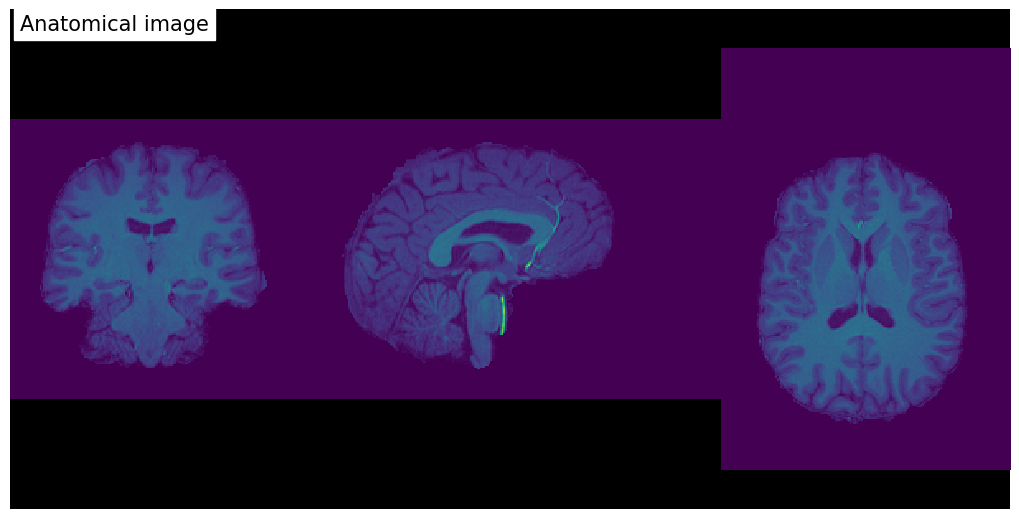

In [57]:
#%matplotlib inline
out_path = f"output/datasink/preproc_wf/sub-{subject_list[0]}/task-flanker"

fig = plt.figure(figsize=(10, 5))

plotting.plot_epi(
    opj(out_path, f"sub-{subject_list[0]}_T1w_ROI_brain.nii.gz"),
    title="Anatomical image",
    display_mode="ortho",
    annotate=False,
    draw_cross=False,
    cmap="viridis",
    figure=fig,
);

Functional image, Mean activation

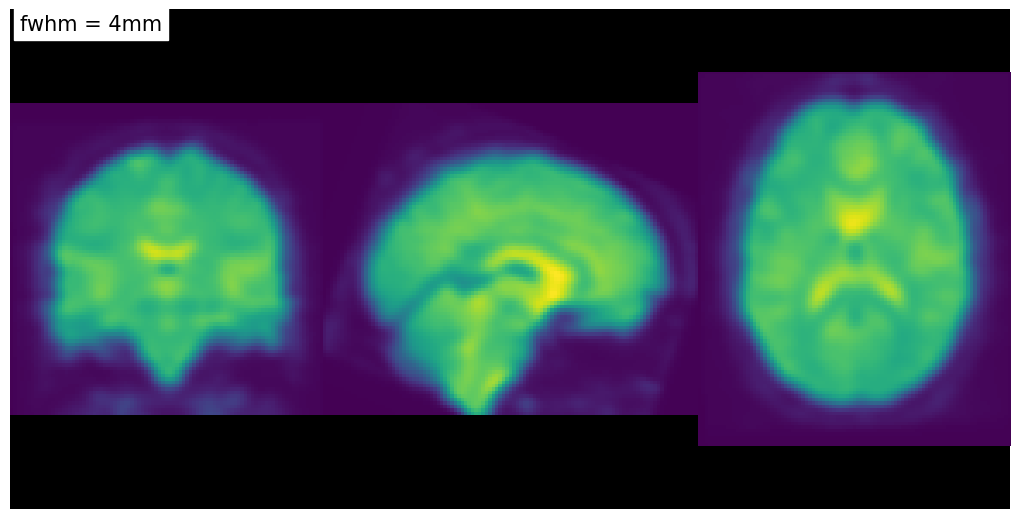

In [60]:
fig = plt.figure(figsize=(10, 5))

if use_spm:
    smooth_prefix = "smooth_"
    smooth_suffix = ""

else:
    smooth_prefix = ""
    smooth_suffix = "_smooth"

plotting.plot_epi(
    image.mean_img(
        opj(
            out_path,
            f"fwhm-4_{smooth_prefix}sub-{subject_list[0]}_task-flanker_run-1_bold_warp{smooth_suffix}.nii",
        )
    ),
    title="fwhm = 4mm",
    display_mode="ortho",
    annotate=False,
    draw_cross=False,
    cmap="viridis",
    figure=fig,
);

## Check shape of preprocessed image

In [61]:
pp_anat = nib.load(
    opj(out_path, f"sub-{subject_list[0]}_T1w_ROI_brain.nii.gz")
).get_fdata()

print(f"\n Shape of anatomical image: {pp_anat.shape}")


 Shape of anatomical image: (176, 256, 170)


In [63]:
pp_func = nib.load(
    opj(
        out_path,
        f"fwhm-4_{smooth_prefix}sub-{subject_list[0]}_task-flanker_run-1_bold_warp{smooth_suffix}.nii",
    )
).get_fdata()

print(f"\n Shape of functional image: {pp_func.shape}")


 Shape of functional image: (91, 109, 91, 142)


## Motion correction: Plot realignment parameters

Shape of motion parameter matrix: (142, 6)
[[-0.00412785  0.00215961  0.0007406   0.10707    -0.0294242  -0.161638  ]
 [-0.00384036  0.00253419  0.0007406   0.0890902  -0.0926662  -0.153343  ]
 [-0.0045382   0.0022053   0.0007406   0.0803522  -0.0117736  -0.177061  ]
 [-0.00414202  0.0022053   0.00073817  0.0722589  -0.0492825  -0.245106  ]
 [-0.00354964  0.00225722  0.00067402  0.0657066  -0.0479288  -0.185811  ]]


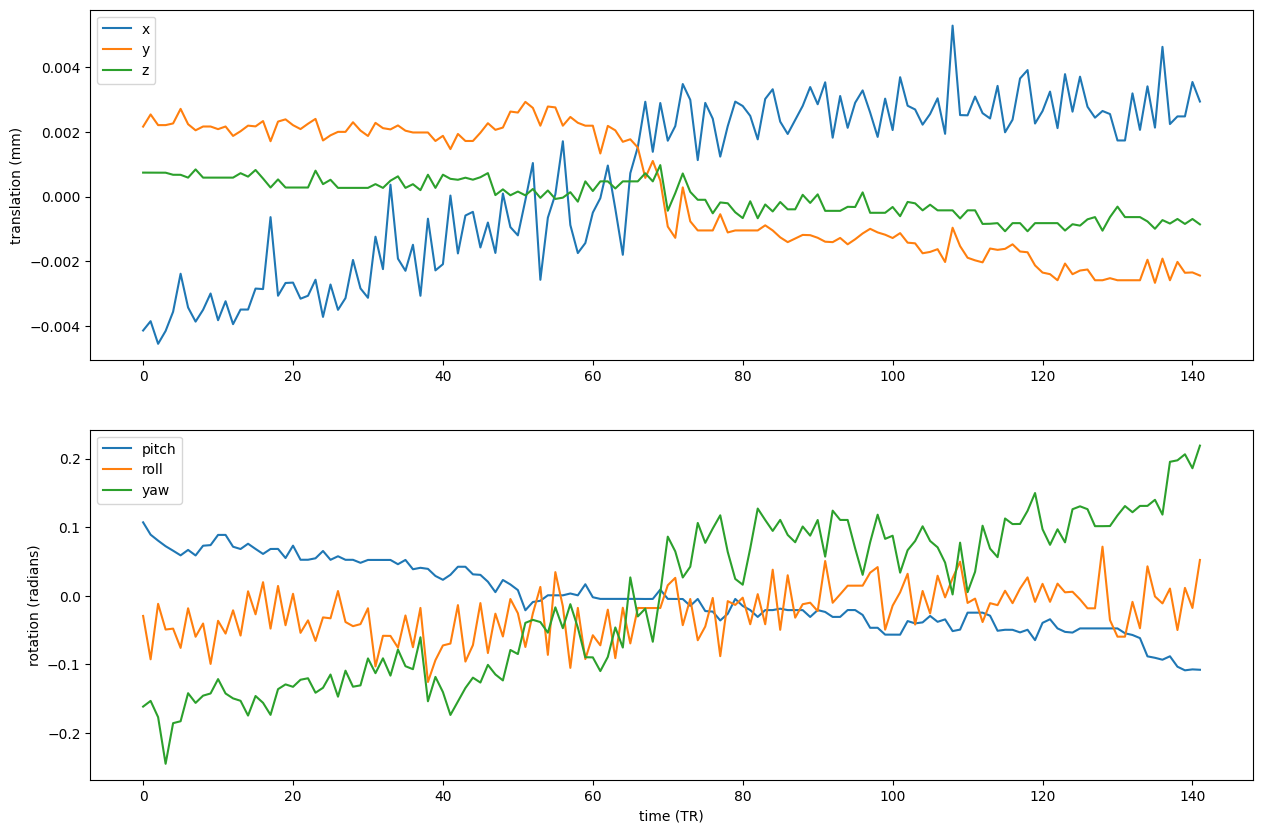

In [64]:
motion_parameters = np.loadtxt(
    f"output/datasink/preproc_wf/sub-{subject_list[0]}/task-flanker/sub-{subject_list[0]}_task-flanker_run-1_bold.par"
)

print(f"Shape of motion parameter matrix: {motion_parameters.shape}")
print(motion_parameters[:5, :])

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

axes[0].plot(motion_parameters[:, :3])
axes[1].plot(motion_parameters[:, 3:])

axes[0].set_ylabel("translation (mm)")
axes[1].set_ylabel("rotation (radians)")
axes[1].set_xlabel("time (TR)")

axes[0].legend(["x", "y", "z"])
axes[1].legend(["pitch", "roll", "yaw"]);

## Signal changes through the processing steps

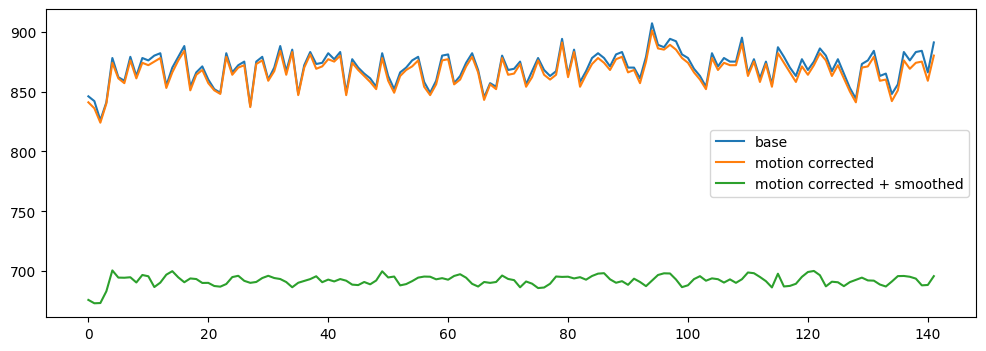

In [66]:
extract_data = nib.load(
    f"{experiment_dir}/{working_dir}/preproc_wf/_subject_id_{subject_list[0]}_task_name_flanker/extract/sub-{subject_list[0]}_task-flanker_run-1_bold_roi.nii"
)

mc_data = nib.load(
    f"{experiment_dir}/{working_dir}/preproc_wf/_subject_id_{subject_list[0]}_task_name_flanker/realigner/sub-{subject_list[0]}_task-flanker_run-1_bold_roi_mcf.nii"
)
smoothed_data = nib.load(
    f"{experiment_dir}/{working_dir}/preproc_wf/_subject_id_{subject_list[0]}_task_name_flanker/_fwhm_4/smooth/{smooth_prefix}sub-{subject_list[0]}_task-flanker_run-1_bold_roi_mcf_st_flirt_warp{smooth_suffix}.nii"
)

# A random voxel
x, y, z = 32, 34, 25
fig = plt.figure(figsize=(12, 4))
plt.plot(extract_data.get_fdata()[x, y, z, :])
plt.plot(mc_data.get_fdata()[x, y, z, :])
plt.plot(smoothed_data.get_fdata()[x, y, z, :])
# plt.plot(detrended_data.get_data()[x, y, z, :])
plt.legend(["base", "motion corrected", "motion corrected + smoothed"]);

## Check extraction

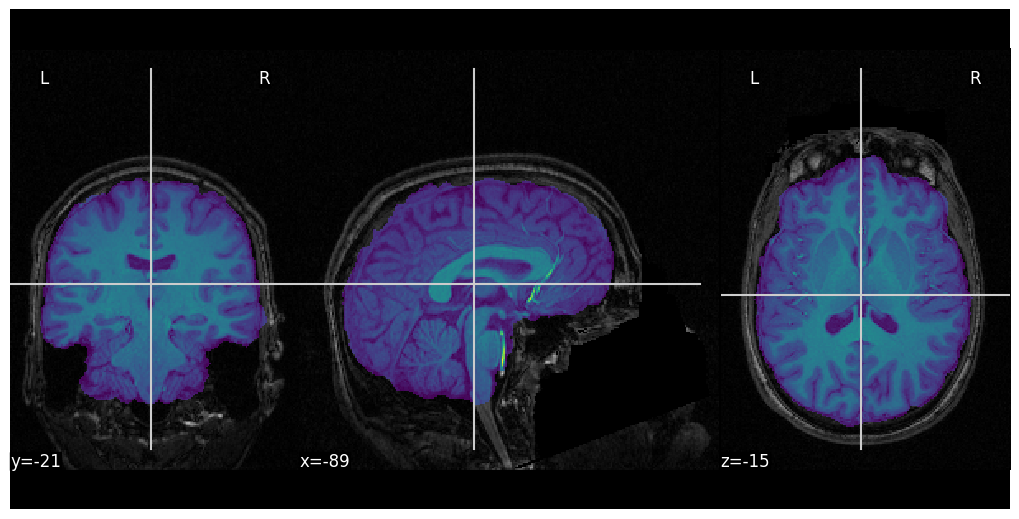

In [67]:
t1_raw = f"{data_dir}/sub-{subject_list[0]}/anat/sub-{subject_list[0]}_T1w.nii.gz"

fig = plt.figure(figsize=(10, 5))
disp_t1 = plotting.plot_anat(t1_raw, dim=-1, figure=fig)
disp_t1.add_overlay(
    f"{experiment_dir}/{output_dir}/preproc_wf/sub-{subject_list[0]}/task-flanker/sub-{subject_list[0]}_T1w_ROI_brain.nii.gz",
)

## Check normalization

### Raw image on mni template

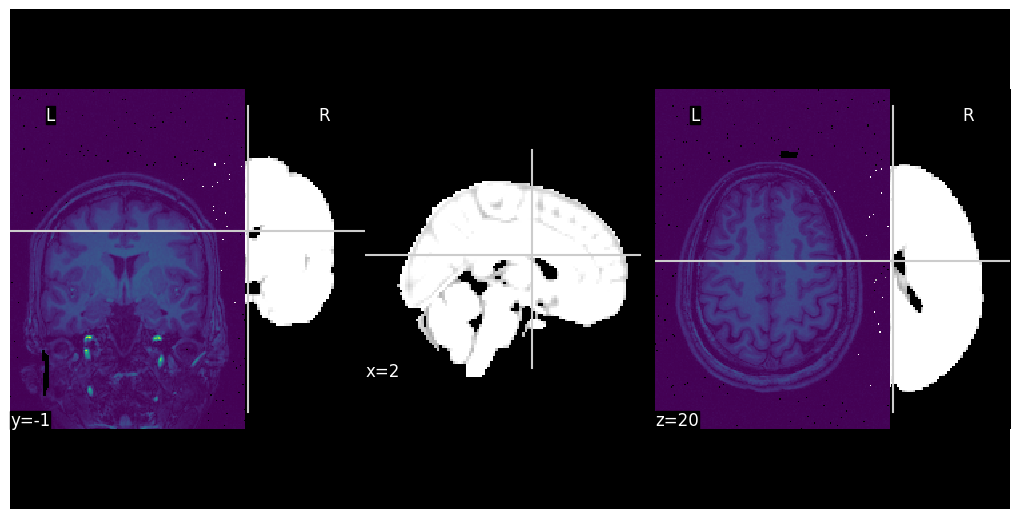

In [68]:
fig = plt.figure(figsize=(10, 5))
display = plotting.plot_anat(mni_template, dim=-1, figure=fig)
display.add_overlay(t1_raw)

### Normalized image on mni template

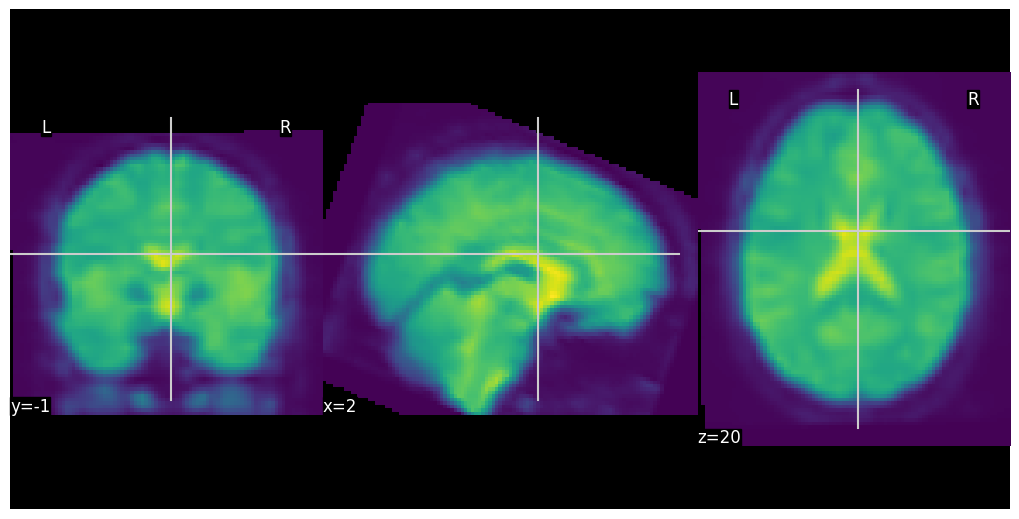

In [69]:
normalized_img = image.mean_img(
    f"{experiment_dir}/{working_dir}/preproc_wf/norm_wf/_subject_id_{subject_list[0]}_task_name_flanker/warp_to_mni/sub-{subject_list[0]}_task-flanker_run-1_bold_roi_mcf_st_flirt_warp.nii"
)

fig = plt.figure(figsize=(10, 5))
display = plotting.plot_anat(mni_template, dim=-1, figure=fig)
display.add_overlay(normalized_img)

# 3. First Level Analysis

In [70]:
import pandas as pd

participants = pd.read_table(f"{data_dir}/participants.tsv")

print(participants.loc[participants.participant_id == f"sub-{subject_list[0]}"])

  participant_id gender    age
1         sub-02      M  22.79


In [71]:
events = pd.read_table(
    f"{data_dir}/sub-{subject_list[0]}/func/sub-{subject_list[0]}_task-flanker_run-1_events.tsv"
)

events.head()

,onset,duration,trial_type,response_time,correctness,StimVar,Rsponse,Stimulus,cond
0,0.0,2.0,congruent_correct,0.510,correct,1,1,congruent,cond001
1,10.0,2.0,incongruent_correct,0.864,correct,2,1,incongruent,cond003
2,20.0,2.0,congruent_correct,0.540,correct,1,1,congruent,cond001
3,30.0,2.0,incongruent_correct,0.863,correct,2,1,incongruent,cond003
4,40.0,2.0,incongruent_correct,0.746,correct,2,1,incongruent,cond003


In [72]:
print(
    f"{len(events.trial_type.unique())} conditions:",
    events.trial_type.unique(),
    sep="\n",
)

2 conditions:
['congruent_correct' 'incongruent_correct']


In [74]:
import nibabel as nib

func = nib.load(
    opj(
        out_path,
        f"fwhm-4_{smooth_prefix}sub-{subject_list[0]}_task-flanker_run-1_bold_warp{smooth_suffix}.nii",
    )
)
print(func.shape)

(91, 109, 91, 142)


/usr/local/lib/python3.10/dist-packages/nilearn/plotting/html_stat_map.py:219: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



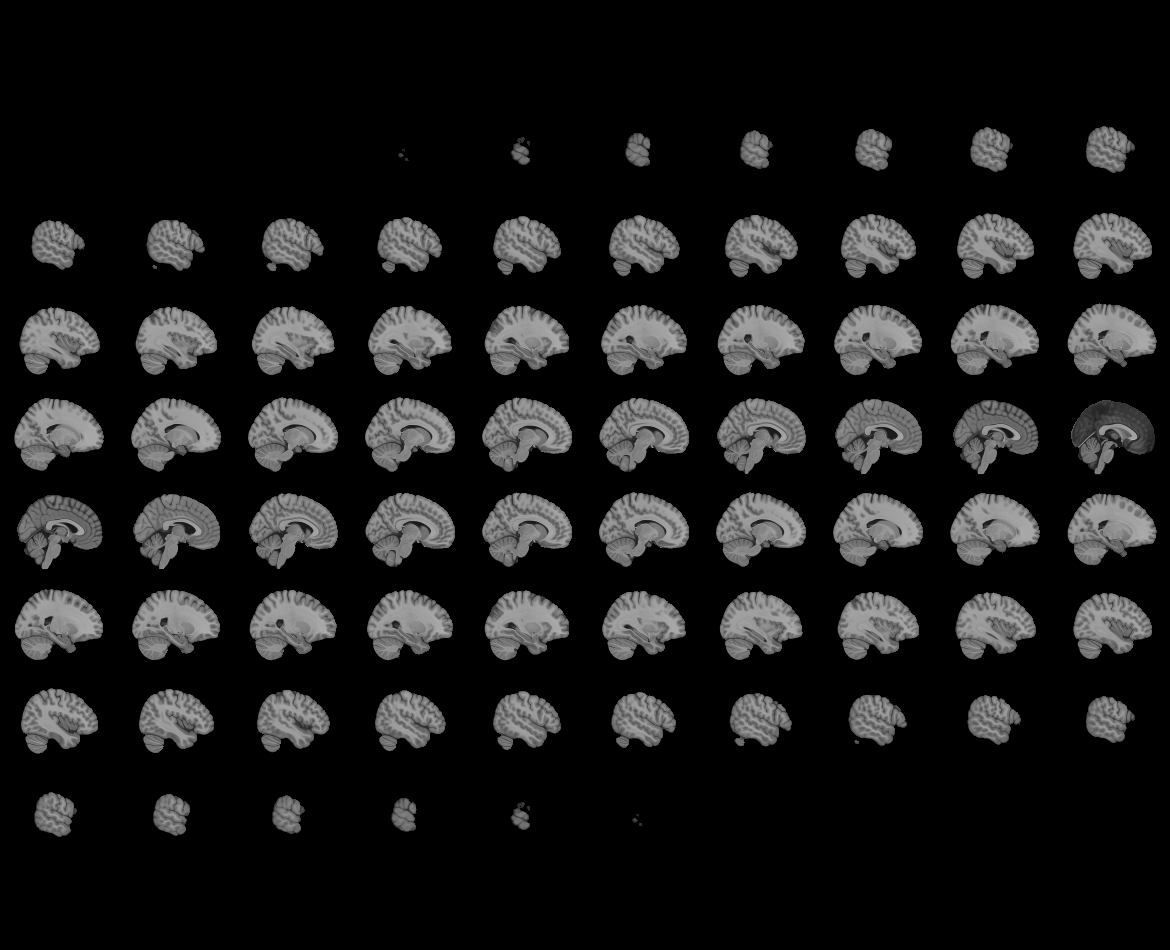
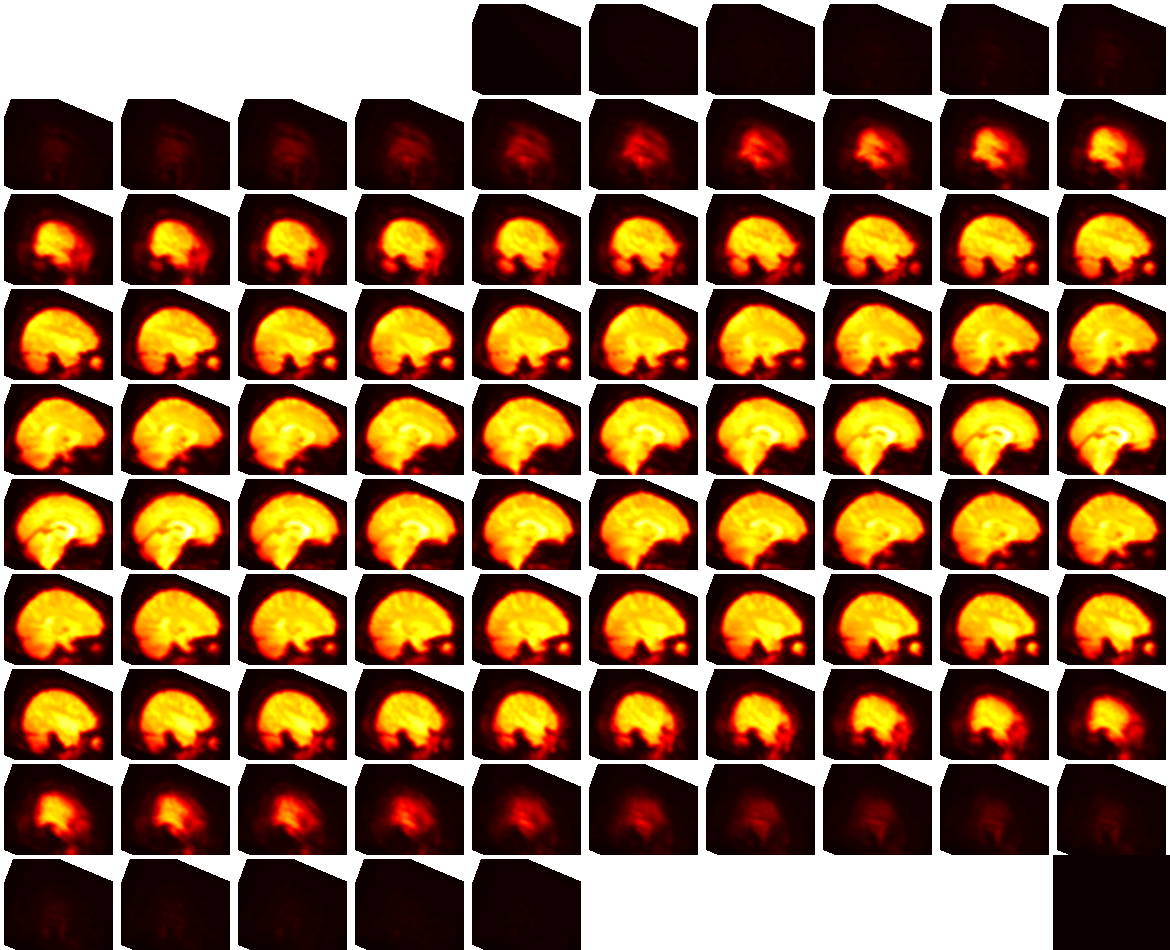

In [75]:
from nilearn import plotting, image

plotting.view_img(image.mean_img(func))

## Specifying model (GLM)

In [76]:
from nilearn.glm.first_level import FirstLevelModel


first_level = FirstLevelModel(
    t_r=TR,
    slice_time_ref=0,
    hrf_model="spm",
    high_pass=0.009,
    drift_model="cosine",
    minimize_memory=False,
)  # for voxelwise attributes like R-Squared)

## Fitting the model to the data

#### Load confounders (motion parameters)

In [77]:
confounds = pd.DataFrame(
    motion_parameters,
    columns=[
        "motion_x",
        "motion_y",
        "motion_z",
        "motion_pitch",
        "motion_roll",
        "motion_yaw",
    ],
)

confounds.head()

,motion_x,motion_y,motion_z,motion_pitch,motion_roll,motion_yaw
0,-0.004128,0.002160,0.000741,0.107070,-0.029424,-0.161638
1,-0.003840,0.002534,0.000741,0.089090,-0.092666,-0.153343
2,-0.004538,0.002205,0.000741,0.080352,-0.011774,-0.177061
3,-0.004142,0.002205,0.000738,0.072259,-0.049282,-0.245106
4,-0.003550,0.002257,0.000674,0.065707,-0.047929,-0.185811


In [78]:
first_level = first_level.fit(
    image.smooth_img(func, 4),
    events=events[["onset", "duration", "trial_type"]],
    confounds=confounds,
)  # 4, because our smoothing kernel had a width of 4

## Design matrix

Shape of design matrix: (142, 14)


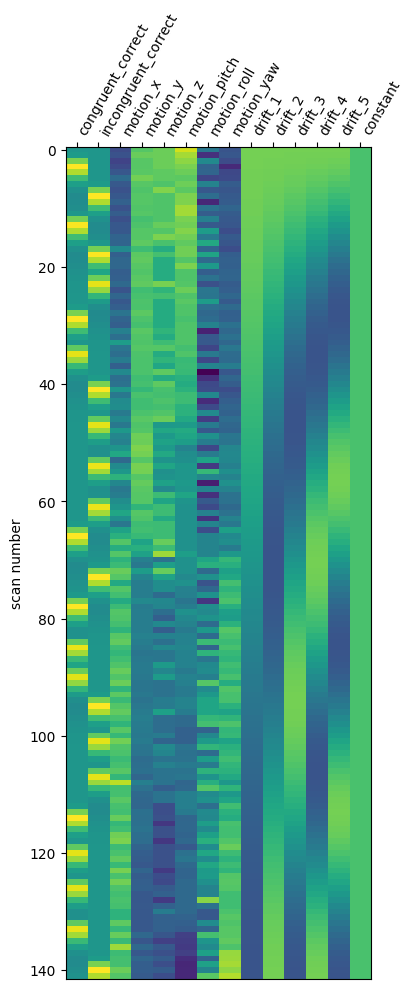

In [79]:
design_matrix = first_level.design_matrices_[0]
print("Shape of design matrix:", design_matrix.shape)
plotting.plot_design_matrix(design_matrix);

## Define contrasts

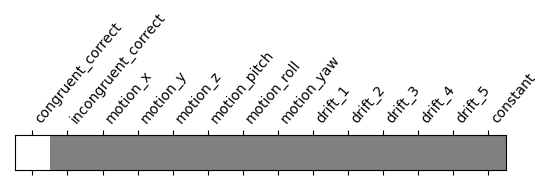

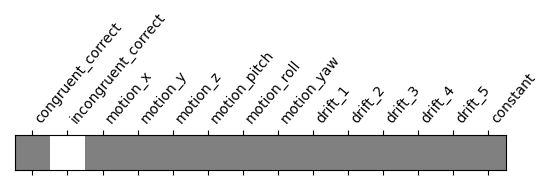

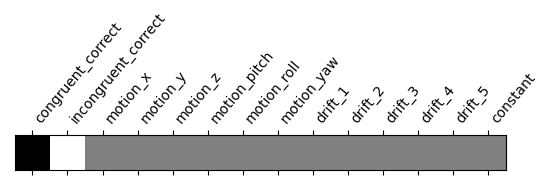

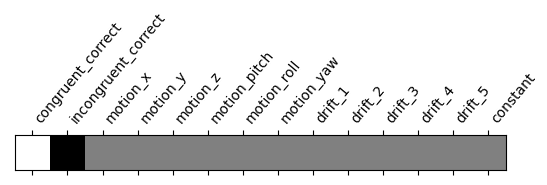

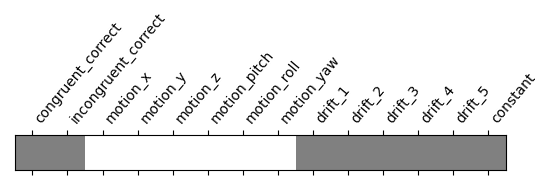

In [80]:
conditions = {
    "congruent_correct > baseline": np.array(
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ),
    "incongruent_correct > baseline": np.array(
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ),
    "incongruent-congruent": np.array([-1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "congruent-incongruent": np.array([1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "motion parameters > baseline": np.array(
        [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
    ),
}


for id, val in conditions.items():
    plotting.plot_contrast_matrix(val, design_matrix=design_matrix)

## Estimate contrasts

### Compute z-maps

In [81]:
z_map_congruent_baseline = first_level.compute_contrast(
    conditions["congruent_correct > baseline"], output_type="z_score"
)
z_map_incongruent_baseline = first_level.compute_contrast(
    conditions["incongruent_correct > baseline"], output_type="z_score"
)
z_map_incongruent_congruent = first_level.compute_contrast(
    conditions["incongruent-congruent"], output_type="z_score"
)
z_map_congruent_incongruent = first_level.compute_contrast(
    conditions["congruent-incongruent"], output_type="z_score"
)
z_map_motion_baseline = first_level.compute_contrast(
    conditions["motion parameters > baseline"], output_type="z_score"
)

### Plot z-maps

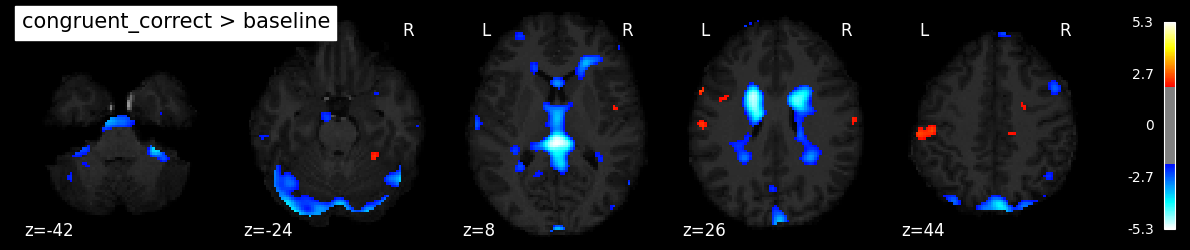

In [82]:
plotting.plot_stat_map(
    z_map_congruent_baseline,
    display_mode="z",
    cut_coords=5,
    threshold=2.0,
    title="congruent_correct > baseline",
    symmetric_cbar=True,
    bg_img=f"{experiment_dir}/{output_dir}/preproc_wf/sub-{subject_list[0]}/task-flanker/warped.nii",
)

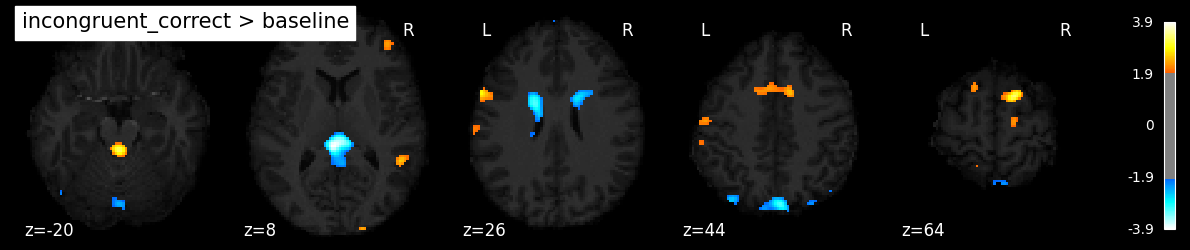

In [83]:
plotting.plot_stat_map(
    z_map_incongruent_baseline,
    display_mode="z",
    cut_coords=5,
    threshold=2.0,
    title="incongruent_correct > baseline",
    symmetric_cbar=True,
    bg_img=f"{experiment_dir}/{output_dir}/preproc_wf/sub-{subject_list[0]}/task-flanker/warped.nii",
)

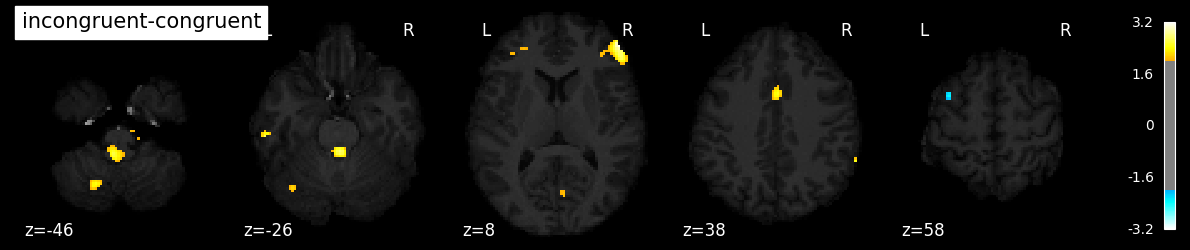

In [84]:
plotting.plot_stat_map(
    z_map_incongruent_congruent,
    display_mode="z",
    cut_coords=5,
    threshold=2.0,
    title="incongruent-congruent",
    symmetric_cbar=True,
    bg_img=f"{experiment_dir}/{output_dir}/preproc_wf/sub-{subject_list[0]}/task-flanker/warped.nii",
)

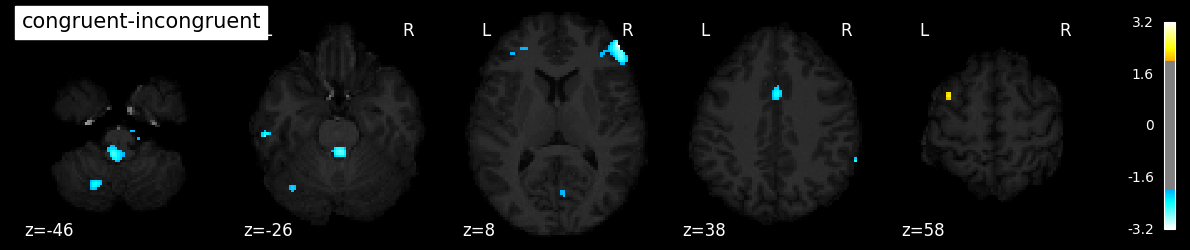

In [85]:
plotting.plot_stat_map(
    z_map_congruent_incongruent,
    display_mode="z",
    cut_coords=5,
    threshold=2.0,
    title="congruent-incongruent",
    symmetric_cbar=True,
    bg_img=f"{experiment_dir}/{output_dir}/preproc_wf/sub-{subject_list[0]}/task-flanker/warped.nii",
)

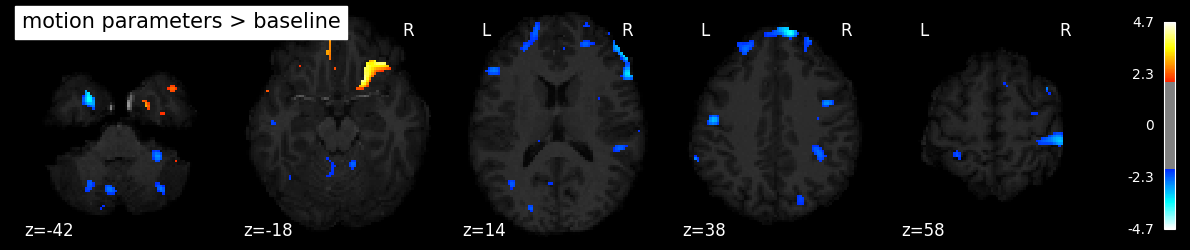

In [86]:
plotting.plot_stat_map(
    z_map_motion_baseline,
    display_mode="z",
    cut_coords=5,
    threshold=2.0,
    title="motion parameters > baseline",
    symmetric_cbar=True,
    bg_img=f"{experiment_dir}/{output_dir}/preproc_wf/sub-{subject_list[0]}/task-flanker/warped.nii",
)